In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import griddata
import scipy
import matplotlib.pyplot as plt
from skimage.morphology import square, dilation
from skimage import data, util
from skimage.measure import label, perimeter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

import seaborn as sns
import os
import re
import json
import sys
import shutil
import pickle

import pipe_util2
import cc3d_util as cu

In [7]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.0.2


In [8]:
def counts_from_df_w_mode_col(df, mode_col, scan_param1, scan_param2):
    # obtain the modes in order. 
    # scan_param2 will be the row.
    counts_list = []
    param1_len = len(df[scan_param1].unique())
    param2_len = len(df[scan_param2].unique())
    
    for a in sorted(df[scan_param1].unique(),reverse=True):
        for f in sorted(df[scan_param2].unique()):
            local_df = df.loc[(df[scan_param1]==a)&(df[scan_param2]==f)].copy()
            counts = [0,0,0]

            i = 0
            while i<len(local_df[mode_col].value_counts()):
                inx = local_df[mode_col].value_counts().index[i]-1
                counts[inx] = local_df[mode_col].value_counts().values[i]
                i = i+1
            counts = np.array(counts)
            counts = counts/counts.sum()
            counts = np.round(counts, 2)
            counts_list.append(counts)
    return counts_list, param1_len, param2_len

In [9]:
def hist_draw(figfolder, counts_list, param1_len, param2_len, name):
    
    figfolder = pipe_util2.folder_verify(figfolder
                                        )
    i = 0
    height = int(8./param2_len*param1_len)
    if height <1:
        height = 1
    fig = plt.figure(figsize = (8, height),frameon=False)
    while i<len(counts_list):

        fig.add_subplot(param1_len,param2_len,i+1)
        counts = counts_list[i]
        
        y = 1.
        x1 = counts[0]/2.
        w1 = counts[0]
        x2 = counts[1]/2.+w1
        w2 = counts[1]
        x3 = counts[2]/2.+w1+w2
        w3 = counts[2]
        
        plt.bar(x1, y, width=w1, color="#EA3526", alpha=0.9)
        plt.bar(x2, y, width=w2, color="#94FAC4")
        plt.bar(x3, y, width=w3, color="#4D51F2")
        
        plt.ylim(0,1)
        plt.xlim(0,1)

        plt.axis("off")

        i = i+1
        
    plt.savefig(figfolder+"%s.pdf"%name, dpi = 200, bbox_inches="tight")


In [10]:
def geo_cluster(name, data_folder, feature_folder):
    
    """
    Collecting geo feature analysis results from simulations.
    """
    
    analysis_folder = os.path.dirname(pipe_util2.folder_verify(feature_folder)[:-1])
    print(analysis_folder)
    
    cluster_folder = analysis_folder + "/" + name + "_cluster"
    cluster_folder = pipe_util2.create_folder(cluster_folder)
#     print(cluster_folder)
    
    geo_csvs = pipe_util2.folder_file_num(feature_folder, ".csv", 1)
    df_list = []
    
    i = 0
    while i<len(geo_csvs):
        df = pd.read_csv(geo_csvs[i], index_col=0)
        df_list.append(df)
        i = i+1
    geo_df = pd.concat(df_list, ignore_index = True)
    
    # removing records that don't have matching part.
    for r in geo_df.rep_inx.unique():

        for i in geo_df.iter_inx.unique():
            temp = geo_df.loc[(geo_df.rep_inx==r) & (geo_df.iter_inx==i)].copy()
            if temp.shape[0]==1:
                print(temp.shape, r, i)
                geo_df.drop(temp.index, inplace = True)
                
    geo_df.to_csv(cluster_folder+"geo_props.csv")
    
    # ------------
    
    scan_param = np.array(geo_df["scan_param"].str.split(" ").to_list()).astype(float).astype(int).T
    fpp_scan = scan_param[0]
    force_scan = scan_param[1]

    geo_df["fpp_scan"] = fpp_scan
    geo_df["force_scan"] = force_scan 
    
    # geo df for timepoint 270 no selection for columns
    geo_270 = geo_df.loc[geo_df.timepoint==270].reset_index(drop=True).copy()

    cols = ['s', 'd', 'd_std', 'area_frac', 'area_convex_frac',
            'peri', 'peri_convex', "minor_major_ratio", 'compact',
            'eccentric', 'circular', 'convexity', 'solidity',
            'radial_dist_cx_std', 'sphericity', 'radial_dist_cn_mean',
           'radial_dist_cn_std']

    # geo features for differences
    geo_df_270 = geo_df.loc[geo_df.timepoint==270][cols].reset_index(drop=True).copy()
    geo_df_90 = geo_df.loc[geo_df.timepoint==90][cols].reset_index(drop=True).copy()

    geo_diff_df = geo_df_270.divide(geo_df_90, axis='index').copy()
    geo_diff_df['dxy_std'] = geo_df[geo_df.timepoint==270].dxy_std.values
    geo_diff_df['dxy_mean'] = geo_df[geo_df.timepoint==270].dxy_mean.values

    # step transform data with scaler
    scalerfile = "scaler1.pkl"
    scaler = pickle.load(open(scalerfile, 'rb'))
    scaled_geo_diff = pd.DataFrame(scaler.transform(geo_diff_df))
    scaled_geo_diff.columns = geo_diff_df.columns
    scaled_geo_diff.index = geo_diff_df.index
    scaled_geo_diff.to_csv(cluster_folder+"scaled_geo_diff.csv")

    # step select properties for 1st step clustering
    scaled_geo_diff_select = scaled_geo_diff[["s", "d","d_std", 
                                              "radial_dist_cn_std",
                                              "radial_dist_cn_mean",
                                              "dxy_std"]].copy()
    kmeanfile1 = "./kmean1.pkl"
    kmean_model = pickle.load(open(kmeanfile1, 'rb'))
    kmean_geo_diff_select = kmean_model.predict(scaled_geo_diff_select)
    geo_270["mode1"] = kmean_geo_diff_select
    geo_270["mode2"] = kmean_geo_diff_select

    mig_mode_num = 0
    nmg_mode_num = 1
    geo_270.loc[geo_270["mode1"]==nmg_mode_num,"mode1"]=3

    # step 2nd clustering
    cols2 = ["d", "s", "d_std", "peri", 'compact', 'circular',]
    scaled_mig_geo_diff_select = scaled_geo_diff[geo_270.mode2==mig_mode_num] # selecting migratory modes
    scaled_geo_diff_select = scaled_mig_geo_diff_select[cols2].copy()

    embeddingfile = "umap2.pkl"
    embedding_modle = pickle.load(open(embeddingfile, 'rb'))
    embedding = embedding_modle.transform(scaled_mig_geo_diff_select)
    embedding = pd.DataFrame(embedding)

    kmeanfile2 = "./kmean2.pkl"
    kmean_model = pickle.load(open(kmeanfile2, 'rb'))
    kmean_geo_diff_select = kmean_model.predict(embedding)
    geo_270.loc[geo_270["mode2"]==mig_mode_num,"mode1"] = kmean_geo_diff_select

    rad_mode_num = 0
    dir_mode_num = 1
    geo_270.loc[geo_270["mode1"]==rad_mode_num,"mode1"]=4
    geo_270.loc[geo_270["mode1"]==dir_mode_num,"mode1"]=5
    geo_270['mode1'] = geo_270['mode1']-2
    geo_270.to_csv(cluster_folder+"geo_270.csv")
    
    # final: 
    # 1 - no migration
    # 2 - radially migration
    # 3 - directional migration
    
    # --------------------
    # plot and save phase graph
    counts_list, param1_len, param2_len = counts_from_df_w_mode_col(geo_270, 
                                                                   "mode1", 
                                                                   "fpp_scan", "force_scan")
    hist_draw(cluster_folder, counts_list, param1_len, param2_len, "3_migration_phase")
    
    return cluster_folder


/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis
/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis/20250129_b0_3_force_fpp_scan_cluster/ folder is freshly created. 

/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis/20250129_b0_3_force_fpp_scan_calc6_features/ has 23100 files
/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis
/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis/20250129_b0_6_force_fpp_scan_cluster/ folder is freshly created. 

/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis/20250129_b0_6_force_fpp_scan_calc6_features/ has 23100 files
/net/capricorn/home/xing/huijing/Migration/20250128_Supplements++/20250129-update-msmm-model-analysis
/net/capricorn/home/xing/huiji

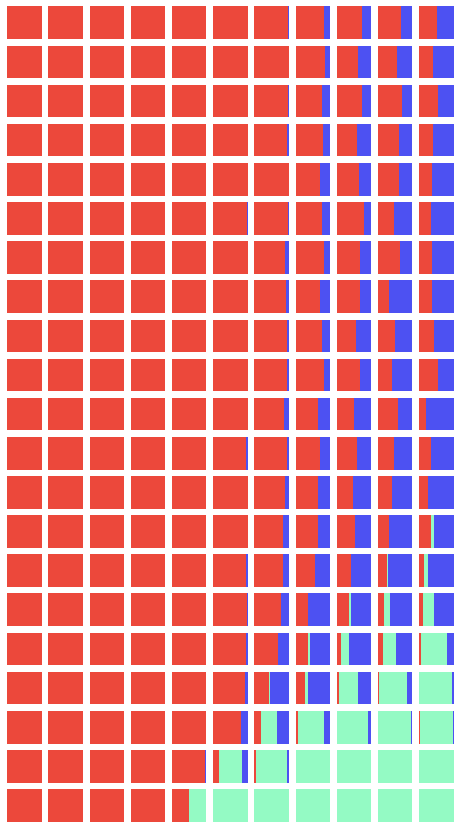

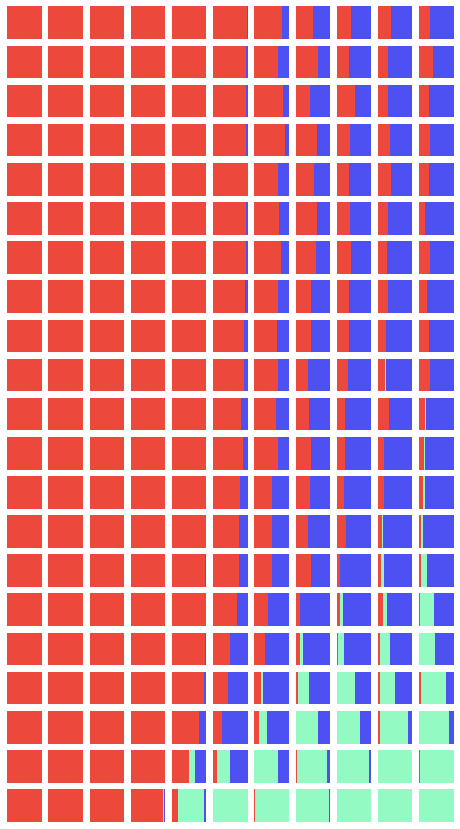

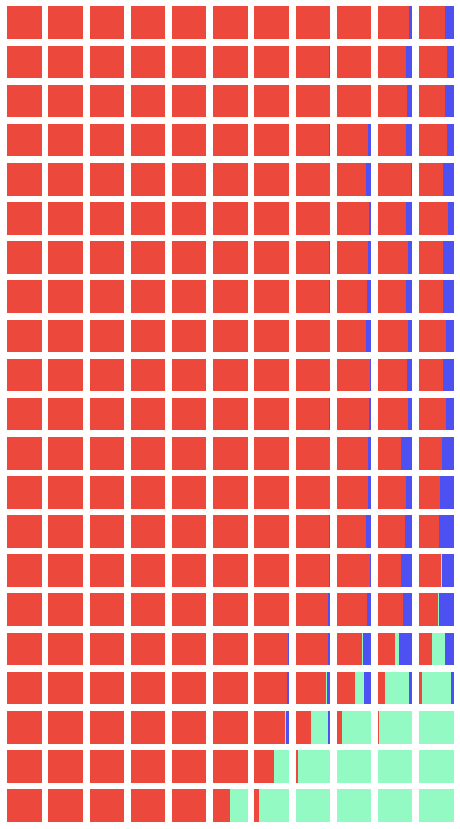

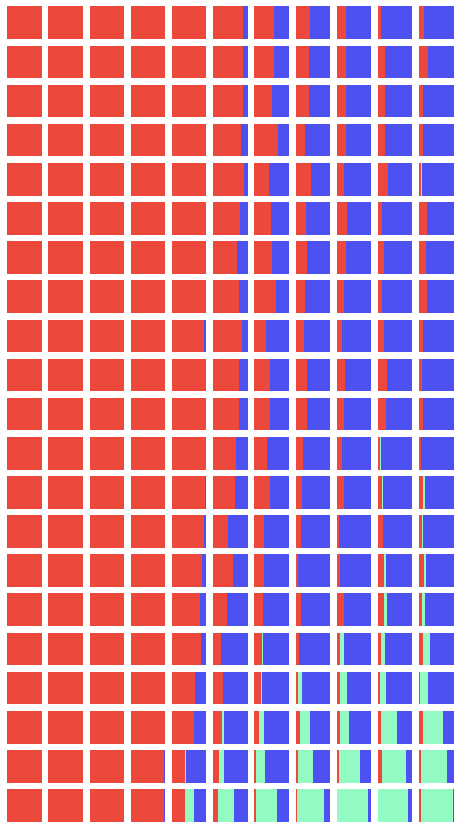

In [12]:
# beta scans
sim_name_list = [
    "20250129_b0_3_force_fpp_scan",
    "20250129_b0_6_force_fpp_scan",
    "20250129_b0_force_fpp_scan",
    "20250129_b1_force_fpp_scan"
]

analysis_folder = "20250129-update-msmm-model-analysis"
analysis_folder = os.path.abspath(analysis_folder)

for i in range(len(sim_name_list)):
    data_folder = "./20250129-update-msmm-model-sim-data/CC3D_data_%s"%sim_name_list[i]
    feature_folder = analysis_folder+"/"+"%s_calc6_features/"%sim_name_list[i]
    cluster_folder = geo_cluster(sim_name_list[i], data_folder, feature_folder)


./20250129-msmm-model-analysis
./20250129-msmm-model-analysis/12222021_formal5_hope_force_fpp_scan_cluster/ folder is freshly created. 

./20250129-msmm-model-analysis/12222021_formal5_hope_force_fpp_scan_cluster/
./20250129-msmm-model-analysis/12222021_formal5_hope_force_fpp_scan_calc6_features/ has 23100 files


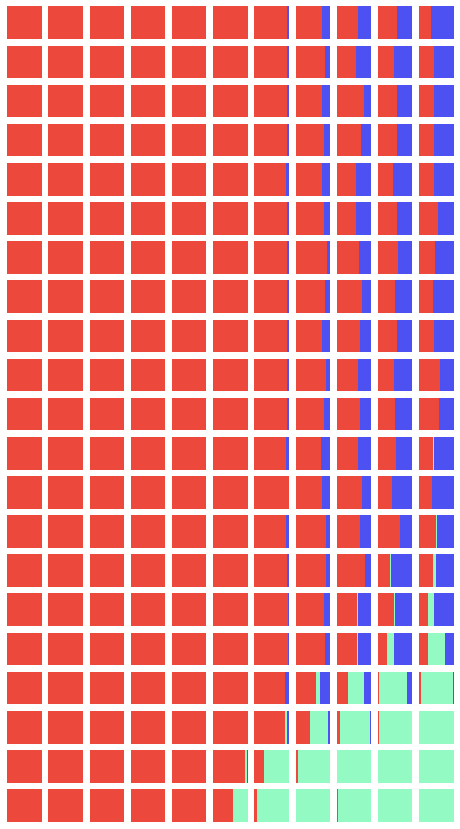

In [29]:
# Original repeat
analysis_folder2 = "./20250129-msmm-model-analysis"
name = "12222021_formal5_hope_force_fpp_scan"
data_folder = "/net/capricorn/home/xing/huijing/Migration/CC3D_data_12222021_formal5_hope_force_fpp_scan/"
feature_folder = analysis_folder2+"/"+"12222021_formal5_hope_force_fpp_scan_calc6_features"

cluster_folder = geo_cluster(name, data_folder, feature_folder)
